<a href="https://colab.research.google.com/github/ErnestoFCh/SQL/blob/main/Proyecto_SMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Miembros
##Franco Chavez Ernesto
##Bautista Cruz Aline Cecilia


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

#Arbol binomial Europeo

In [2]:
def binomial_tree_european(S, K, T, r, sigma, N, opcion):

    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Inicializar la matriz de precios, corresponde a una matriz diagonal superior
    prices = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            prices[j, i] = S * (u ** (i - j)) * (d ** j)

    # Inicializar la matriz de valores de opción
    option_values = np.zeros((N + 1, N + 1))
    if opcion == 'call':
        option_values[:, N] = np.maximum(0, prices[:, N] - K)
    elif opcion == 'put':
        option_values[:, N] = np.maximum(0, K - prices[:, N])

    # Retroceder a través del árbol
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_values[j, i] = np.exp(-r * dt) * (p * option_values[j, i + 1] + (1 - p) * option_values[j + 1, i + 1])
    frame_prices = pd.DataFrame(prices)
    frame_options = pd.DataFrame(option_values)
    return float(option_values[0, 0]),frame_prices,frame_options


#Arbol Binomial Americano

In [3]:
def binomial_tree_american(S, K, T, r, sigma, N, opcion):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Inicializar la matriz de precios del subyacente
    prices = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            prices[j, i] = S * (u ** (i - j)) * (d ** j)

    # Inicializar la matriz de valores de la opción
    option_value = np.zeros((N + 1, N + 1))
    if opcion == 'call':
        option_value[:, N] = np.maximum(0, prices[:, N] - K)
    elif opcion == 'put':
        option_value[:, N] = np.maximum(0, K - prices[:, N])

    # Retroceder en el árbol binomial
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_value[j, i] = np.exp(-r * dt) * (p * option_value[j, i + 1] + (1 - p) * option_value[j + 1, i + 1])
            if opcion == 'call':
                option_value[j, i] = np.maximum(option_value[j, i], prices[j, i] - K)
            elif opcion == 'put' :
                option_value[j, i] = np.maximum(option_value[j, i], K - prices[j, i])
    frame_prices = pd.DataFrame(prices)
    frame_options = pd.DataFrame(option_value)
    return float(option_value[0, 0]),frame_prices,frame_options

#Black-Scholes

In [4]:
def Black_Scholes(S, K, T, r, sigma, opcion):
  d1 = (np.log(S / K) + (r + (sigma ** 2 / 2) )* T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T) )
  if opcion == 'call':
     return (S * norm.cdf(d1) )- (K * np.exp(-r * T) * norm.cdf(d2))
  elif opcion == 'put':
      return (K * np.exp(-r * T) * norm.cdf(-d2) ) - (S * norm.cdf(-d1))

In [5]:
def option (S, K, T, r, sigma, N, opcion, tipo):
  Black = Black_Scholes(S, K, T, r, sigma, opcion)

  if tipo == 'american':
    tree, frame_prices, frame_options = binomial_tree_american(S, K, T, r, sigma, N, opcion)
    return tree, Black, frame_american

  elif tipo == 'europe':
    tree, frame_prices, frame_options = binomial_tree_european(S, K, T, r, sigma, N, opcion)
    return tree, Black, frame_prices, frame_options

#Grafica de convergencia

In [6]:
def convergencia(S, K, T, r, sigma, N, opcion, I):

  Black = Black_Scholes(S, K, T, r, sigma, opcion)
  precios_american = []
  precios_europe = []
  flag1 = False
  flag2 = False
  n = 0
  k = 0

  for i in range(1, I):

    american, _ , _ = binomial_tree_american(S, K, T, r, sigma, i, opcion)
    europe, _ , _ = binomial_tree_european(S, K, T, r, sigma, i, opcion)

    precios_american.append(american)
    precios_europe.append(europe)

    difference_american = abs(american - Black)
    difference_europe = abs(europe - Black)

    if difference_american <= 0.01:
      if not flag1:
        dif1 = difference_american
        n = i
        flag1 = True

    if difference_europe <= 0.01:
      if not flag2:
        dif2 = difference_europe
        k = i
        flag2 = True

  #gradicar
  plt.plot(precios_american, label='Americano')
  plt.plot(precios_europe, label='Europeo')
  plt.plot(np.ones(I) * Black, label='Black-Scholes')
  plt.title('Convergencia de la opción call')

  plt.xlabel('N')
  plt.ylabel('Precio')
  plt.legend()

  plt.show()

  print(f'Precio Black-Scholes: {Black}')

  print(f"Diferencia americano: {dif1}")
  print(f"N: {n}")
  print(f'Precio: {precios_american[n-1]}')

  print(f"Diferencia europe: {dif2}")
  print(f"N: {k}")
  print(f'Precio: {precios_europe[k-1]}')

#Pregunta 1

In [7]:
# tipo: american , europe
# option: call , put
S = 150
K = 165
T = 8/12
r = 0.12
sigma = 0.41
N = 7
tipo = 'europe'
opcion = 'call'

In [8]:
dt = T / N
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
p = (np.exp(r * dt) - d) / (u - d)
print(f"u: {u}")
print(f"d: {d}")
print(f"p: {p}")

u: 1.1348820751268855
d: 0.881148818821722
p: 0.5137099886906582


In [9]:
tree, black, frame_prices, frame_options= option (S, K, T, r, sigma, N, opcion, tipo)
print(f"La opcion {tipo}a tipo {opcion} tiene un precio ${tree:.4f}" )

La opcion europea tipo call tiene un precio $18.7624


In [10]:
frame_prices

,0,1,2,3,4,5,6,7
0,150.0,170.232311,193.193599,219.251952,248.825110,282.387158,320.476123,363.702608
1,0.0,132.172323,150.000000,170.232311,193.193599,219.251952,248.825110,282.387158
2,0.0,0.000000,116.463486,132.172323,150.000000,170.232311,193.193599,219.251952
3,0.0,0.000000,0.000000,102.621663,116.463486,132.172323,150.000000,170.232311
4,0.0,0.000000,0.000000,0.000000,90.424957,102.621663,116.463486,132.172323
5,0.0,0.000000,0.000000,0.000000,0.000000,79.677844,90.424957,102.621663
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,70.208038,79.677844
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.863730


In [11]:
frame_options

,0,1,2,3,4,5,6,7
0,18.762401,28.888256,43.413367,63.378750,89.386373,121.115811,157.351103,198.702608
1,0.000000,8.509063,14.226945,23.348348,37.402704,57.980605,85.700090,117.387158
2,0.000000,0.000000,2.669896,4.927495,9.053393,16.548559,30.068578,54.251952
3,0.000000,0.000000,0.000000,0.348107,0.685421,1.349593,2.657347,5.232311
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#Pregunta 2

In [12]:
N= 55

In [13]:
#Calls
call = 'call'
Call_europe,_,_= binomial_tree_european(S, K, T, r, sigma, N, call)
Call_american,_,_ = binomial_tree_american(S, K, T, r, sigma, N, call)

In [14]:
#Puts
put = 'put'
Put_europe,_,_= binomial_tree_european(S, K, T, r, sigma, N, put)
Put_american,_,_ = binomial_tree_american(S, K, T, r, sigma, N, put)

In [15]:
#Black
#Call
Call_black = Black_Scholes(S, K, T, r, sigma, call)
#put
opcion2 = 'put'
Put_black = Black_Scholes(S, K, T, r, sigma, put)

In [16]:
#mostrar resultados
Data = [
    [Call_europe, Call_american, Put_europe, Put_american, Call_black, Put_black]
]
Heads = ['Call_europe', 'Call_american', 'Put_europe', 'Put_american','Call_black','Put_black']
df = pd.DataFrame(Data, columns=Heads)
df

,Call_europe,Call_american,Put_europe,Put_american,Call_black,Put_black
0,19.03296,19.03296,21.347157,23.716439,18.957082,21.27128


#Pregunta 3

In [17]:
#numero de iteraciones
I = 100

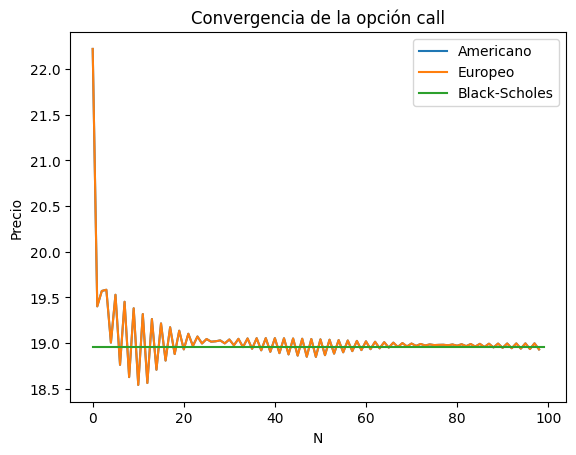

Precio Black-Scholes: 18.957082400783705
Diferencia americano: 0.0011079974387158131
N: 34
Precio: 18.95597440334499
Diferencia europe: 0.0011079974387158131
N: 34
Precio: 18.95597440334499


In [18]:
#Convergencia Calls
call = 'call'
convergencia(S, K, T, r, sigma, N, call, I)